# Sinor Project
## Rice Dectection
In this project, it about classifly rices gain.

In [1]:
import cv2
import math
import time
import numpy as np
import random as rng
import csv
from matplotlib import pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display, HTML,clear_output
%matplotlib inline

## Read File Path

In [2]:
import os, fnmatch
def filePath(path="05.11.61"):
    paths = "assets/" + path + "/"
    pattern = "*[.JPG,.png]"
    list = []
    for file in os.listdir(paths):
        if fnmatch.fnmatch(file, pattern):
            list.append(paths+file)
    return list

## Color Segment

## Auto White Balance

In [3]:
def whiteBalance(img):
    out = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(out[:, :, 1])
    avg_b = np.average(out[:, :, 2])
    out[:, :, 1] = out[:, :, 1] - ((avg_a - 128) * (out[:, :, 0] / 255.0) * 1.1)
    out[:, :, 2] = out[:, :, 2] - ((avg_b - 128) * (out[:, :, 0] / 255.0) * 1.1)
    out = cv2.cvtColor(out, cv2.COLOR_LAB2BGR)
    return out

## Plot Histrogram

In [4]:
def plotHist(inputImage,cvt='rgb',w=False):
    color = (cvt[0],cvt[1],cvt[2])
    data = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([inputImage],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        data.append(histr)
        plt.xlim([0,256])
    plt.show()
    
#  Write File
    if w :
        myFile = open('example2.csv', 'w')
        with myFile:
            writer = csv.writer(myFile)
            writer.writerows(data)

## Plot Image

In [5]:
global riceImage,riceImageWB,mask
def plotImage(inputImage,path=False):
    inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    riceImage = cv2.cvtColor(inputImage,cv2.COLOR_BGR2RGB)
    riceImageWB = whiteBalance(inputImage)
    riceImageWBGray = cv2.cvtColor(riceImageWB, cv2.COLOR_BGR2GRAY)
    riceImageWBGray = cv2.blur(riceImageWBGray,(15,15))
    
    _hMin,_sMin,_vMin = 0, 48, 80
    _hMax,_sMax,_vMax = 20, 255, 255
    riceImageHSV = cv2.cvtColor(inputImage,cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(riceImageHSV,(_hMin,_sMin,_vMin),(_hMax,_sMax,_vMax))
    riceOutput = cv2.bitwise_and(riceImage,riceImage,mask = mask)

    plt.figure(figsize=(10,10))
    plt.title('Rice Image')
    plt.imshow(riceImage,cmap='gray')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.title('Rice Image With WhiteBalance')
    riceImageWB = cv2.cvtColor(riceImageWB, cv2.COLOR_BGR2RGB)
    plt.imshow(riceImageWB,cmap='gray')
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.title('Segmentation')
    plt.imshow(mask, cmap='gray')
    plt.show()
    
    plt.title('Histogram Of WhiteBalance Rice Image')
    plotHist(riceImageWB)
    if path :
        riceImageWB = cv2.cvtColor(riceImageWB, cv2.COLOR_BGR2RGB)
        cv2.imwrite(path+'_riceWhiteBalance.jpg',riceImageWB)
        cv2.imwrite(path+'_segmentation.jpg',mask)

## Plot Image Throshould

In [6]:
def plotImageByThroshold(inputImage,path=False):
    inputImageGray = cv2.cvtColor(inputImage, cv2.COLOR_BGR2GRAY)
    riceImage = cv2.cvtColor(inputImage,cv2.COLOR_BGR2RGB)
    riceImageWB = whiteBalance(inputImage)
    riceImageWBGray = cv2.cvtColor(riceImageWB, cv2.COLOR_BGR2GRAY)
#     riceImageWBGray = cv2.blur(riceImageWBGray,(15,15))
    
    mask = cv2.threshold(riceImageWBGray,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    mask = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(mask,kernel,iterations=3)

    riceImageWB = cv2.cvtColor(riceImageWB, cv2.COLOR_BGR2RGB)
    riceOutput = cv2.bitwise_and(riceImageWB,riceImageWB,mask = mask)

    plt.figure(figsize=(10,10))
    plt.title('Rice Image')
    plt.imshow(riceImage,cmap='gray')
    plt.show()

    plt.figure(figsize=(10,10))
    plt.title('Rice Image With WhiteBalance')
    plt.imshow(riceImageWB,cmap='gray')
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.title('Segmentation')
    plt.imshow(mask, cmap='gray')
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.title('Rice Segment')
    plt.imshow(riceOutput, cmap='gray')
    plt.show()
    
    plt.title('Histogram Of WhiteBalance Rice Image')
    plotHist(riceImageWB)
    if path :
        riceImageWB = cv2.cvtColor(riceImageWB, cv2.COLOR_BGR2RGB)
        riceOutput = cv2.cvtColor(riceOutput, cv2.COLOR_BGR2RGB)
        cv2.imwrite(path[:-4]+'_riceWhiteBalance.jpg',riceImageWB)
        cv2.imwrite(path[:-4]+'_segmentation.jpg',mask)
        cv2.imwrite(path[:-4]+'_riceSegmentation.jpg',riceOutput)

## Color Correction

Avg color [168.74291008 155.03096214 161.05079481]


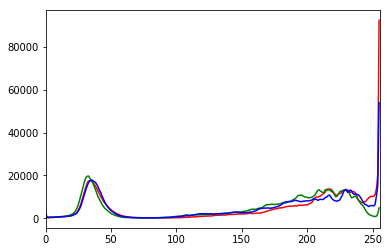

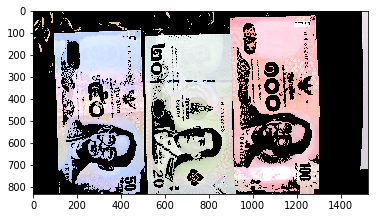

[214. 213. 205.] [-0.  0.  0.] [202. 213. 246.] [240. 230. 235.] [247. 191. 192.]


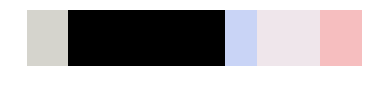

Red is  [247. 191. 192.]
Green is  [214. 213. 205.]
Blue is  [202. 213. 246.]


In [7]:
from sklearn.cluster import KMeans

def avgColor(img):
    avg_img = np.array(img)
    avg_color_per_row = np.average(avg_img, weights=(avg_img > 0), axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    print('Avg color',avg_color)
    return avg_color

def find_histogram(clt):
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist
def plot_bar(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    start = 0
    colorList = []
    for (percent, color) in zip(hist, centroids):
        x = np.around(color)
        x.astype(int)
        colorList.append(x)
        end = start + (percent * 300)
        cv2.rectangle(bar, (int(start), 0), (int(end), 50),
                      color.astype("uint8").tolist(), -1)
        start = end
    color1, color2, color3, color4, color5 = colorList
    print(color1, color2, color3, color4, color5)
    sumList = np.sum(colorList, axis=1)
    maxIndex = np.argmax(sumList)
    minIndex = np.argmin(sumList)
    colorList.pop(maxIndex)
    colorList.pop(minIndex)
    refRBGs = colorList
    return [bar, refRBGs]

img = cv2.imread(filePath()[2])
img = img[3200:,1500:,...]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

avg_color = avgColor(img)

plotHist(img,cvt='rgb',w=False)
imgGray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
mask = cv2.threshold(imgGray,190,255,cv2.THRESH_BINARY)[1]
img = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(img)
plt.show()

img = img.reshape((img.shape[0] * img.shape[1],3)) #represent as row*column,channel number
clt = KMeans(n_clusters=5) #cluster number
clt.fit(img)

hist = find_histogram(clt)
bar, RGBs = plot_bar(hist, clt.cluster_centers_)
r, g, b = np.argmax(RGBs, axis=0)

plt.axis("off")
plt.imshow(bar)
plt.show()

print('Red is ', RGBs[r])
print('Green is ', RGBs[g])
print('Blue is ', RGBs[b])

Avg color [190.11070918 189.24494864 199.41705   ]


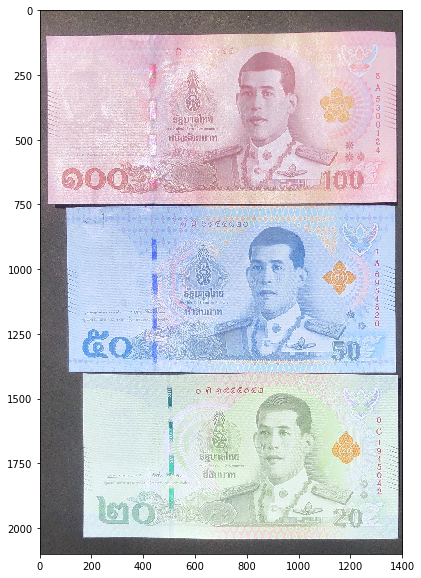

assets/07.05.62/07.05.62_12.25.JPG
Avg color [179.30022394 181.44528526 188.98523911]


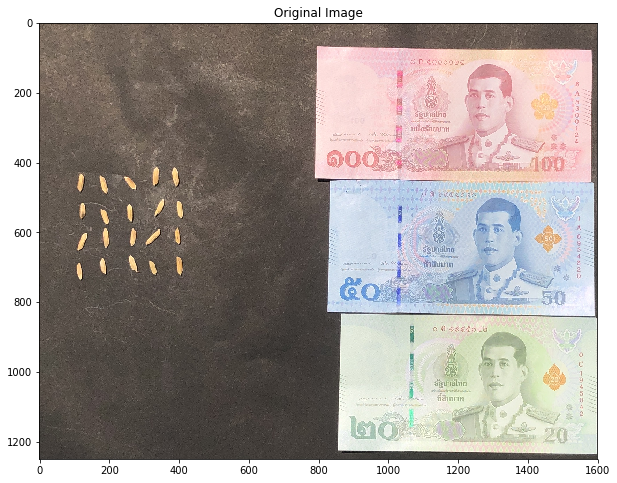

Avg color [190.11070918 189.24494864 199.41705   ]
RGBFactor =  [1.         0.98367777 0.99519607]


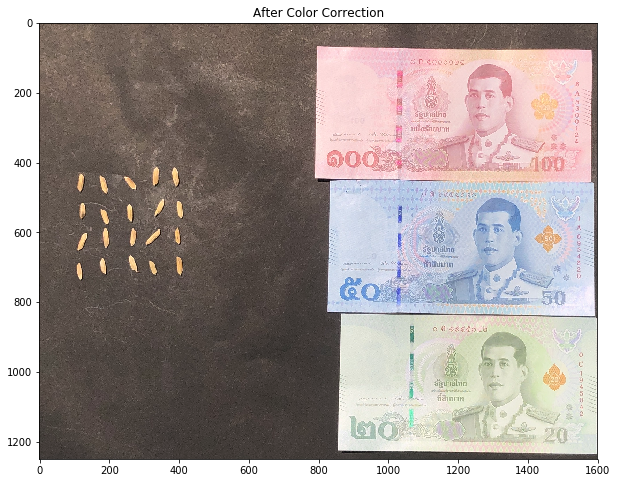

CPU times: user 2.21 s, sys: 218 ms, total: 2.43 s
Wall time: 2.33 s


In [20]:
%%time
np.seterr(divide='ignore', invalid='ignore')
baseImg = cv2.imread(filePath('07.05.62')[-1])
baseImg = cv2.cvtColor(baseImg, cv2.COLOR_BGR2RGB)
baseImg = baseImg[800:2900,500:1900]
avgColor(baseImg)
plt.figure(figsize=(10,10))
plt.imshow(baseImg)
plt.show()

def colorCorrection(img, avgRGB):
    plt.figure(figsize=(10,10))
    plt.title('Original Image')
    plt.imshow(img)
    plt.show()
#     RGBBase = np.array([196,184,169])
    RGBBase = np.array(avgColor(baseImg))
    RGBRaw = np.array(avgRGB)
    RGBBase = RGBBase/RGBBase[0]
    RGBRaw = RGBRaw/RGBRaw[0]
    RGBFactor = RGBBase/RGBRaw
    print('RGBFactor = ',RGBFactor)
    imgCC = np.array(img)
    # RGB
    red = np.copy(imgCC[:,:,0])
    greenFactor = RGBFactor[1]
    green = imgCC[:,:,1] * greenFactor
    blueFactor = RGBFactor[2]
    blue = imgCC[:,:,2] * blueFactor
    # Green
    imgCC[:,:,1] = np.where(blue > 255, (255/blue)*green, green)
    imgCC[:,:,1] = np.where((green > 255) & (green >= blue),255, imgCC[:,:,1])
    # Blue
    imgCC[:,:,2] = np.where(green > 255, (255/green)*blue, blue)
    imgCC[:,:,2] = np.where((blue > 255) & (blue >= green),255, imgCC[:,:,2])
    # Red
    imgCC[:,:,0] = np.where((green > 255) | (blue > 255), 
                            np.where(green > blue, (255/green)*red , (255/blue)*red), red)
    plt.figure(figsize=(10,10))
    plt.title('After Color Correction')
    plt.imshow(imgCC)
    plt.show()
    
    return imgCC

img = cv2.imread(filePath('07.05.62')[2])
print(filePath('07.05.62')[2])
rawImg = img[1000:2250,1000:2600]
rawImg = cv2.cvtColor(rawImg, cv2.COLOR_BGR2RGB)
colorCorrection(rawImg,avgColor(img[1000:2250,1700:2600]))

## Avg Color Yellow Rice

07.05.62_12.15_Crop .png
[233.65452261306532, 212.71960146400977, 151.91676833401112]
[1.         0.91040224 0.65017688]


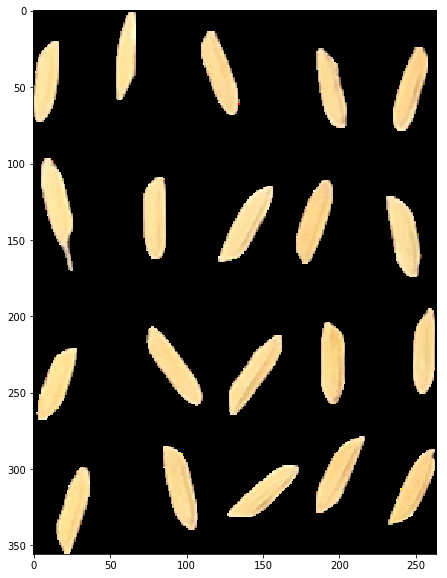

In [106]:
img = cv2.imread(filePath('07.05.62')[-1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(filePath('07.05.62')[-1][16:])
avgImg = [0,0,0]
# avgImg[0] = np.average(img[:,:,0], weights=(img[:,:,0] > 0))
# avgImg[1] = np.average(img[:,:,1], weights=(img[:,:,1] > 0))
# avgImg[2] = np.average(img[:,:,2], weights=(img[:,:,2] > 0))
# print(avgImg)
# print(avgImg/avgImg[0])
avgImg[0] = np.average(img[:,:,0], weights=((img[:,:,0] > 0) & (img[:,:,0] < 255)))
avgImg[1] = np.average(img[:,:,1], weights=((img[:,:,1] > 0) & (img[:,:,1] < 255)))
avgImg[2] = np.average(img[:,:,2], weights=((img[:,:,2] > 0) & (img[:,:,2] < 255)))
print(avgImg)
print(avgImg/avgImg[0])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

## Avg Color Red Rice

07.05.62_12.25_Crop.png
[237.30048878027105, 203.66916269571138, 144.4615973462618]
[1.         0.85827536 0.60877075]


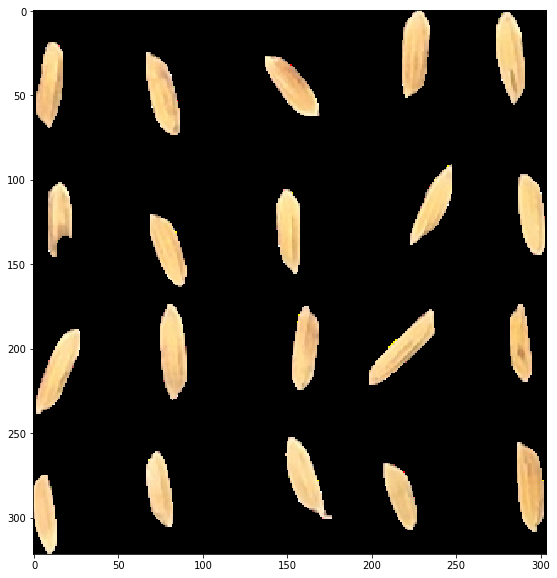

In [108]:
img = cv2.imread(filePath('07.05.62')[-3])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(filePath('07.05.62')[-3][16:])
avgImg = [0,0,0]
# avgImg[0] = np.average(img[:,:,0], weights=(img[:,:,0] > 0))
# avgImg[1] = np.average(img[:,:,1], weights=(img[:,:,1] > 0))
# avgImg[2] = np.average(img[:,:,2], weights=(img[:,:,2] > 0))
# print(avgImg)
# print(avgImg/avgImg[0])
avgImg[0] = np.average(img[:,:,0], weights=((img[:,:,0] > 0) & (img[:,:,0] < 255)))
avgImg[1] = np.average(img[:,:,1], weights=((img[:,:,1] > 0) & (img[:,:,1] < 255)))
avgImg[2] = np.average(img[:,:,2], weights=((img[:,:,2] > 0) & (img[:,:,2] < 255)))
print(avgImg)
print(avgImg/avgImg[0])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

## Plot Connected Components

In [537]:
def deleteSmall(inputImg, size):
        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(inputImg, connectivity=8)
        sizes = stats[1:, -1]; nb_components = nb_components - 1
        
        min_size = size  

        img = np.zeros((inputImg.shape), np.uint8)
        #for every component in the image, you keep it only if it's above min_size
        for i in range(0, nb_components):
            if sizes[i] >= min_size:
                img[output == i + 1] = 255
        return img

def plotConnectedComponents(inputImage):
    cropImage = inputImage
    riceImage = cv2.cvtColor(cropImage,cv2.COLOR_BGR2RGB)
    riceImageGray = cv2.cvtColor(cropImage, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    opening = cv2.morphologyEx(riceImageGray,cv2.MORPH_OPEN,kernel, iterations = 2)

    I2 = riceImageGray - opening

    mask = cv2.threshold(I2,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask2 = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel, iterations = 2)
    
    mask = deleteSmall(mask2, 300)
    
    stackImg = np.concatenate((riceImageGray, mask), axis=1)
    
    plt.figure(figsize=(10,10))
    plt.imshow(mask2, cmap = 'gray')
    plt.show()
    
    plt.figure(figsize=(20,20))
    plt.title('After Opening')
    plt.imshow(stackImg, cmap = 'gray')
    plt.show()
    
    # sure background area
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    sure_bg = cv2.dilate(mask,kernel,iterations=3)

    riceOutput = cv2.bitwise_and(riceImage,riceImage,mask = mask)
    
    distanceTransformOutput = cv2.distanceTransform(mask,cv2.DIST_L2,3)
    plt.figure(figsize=(10,10))
    plt.title('distanceTransformOutput')
    plt.imshow(distanceTransformOutput,cmap='gray')
    plt.show()
    
    maxDistance = np.max(distanceTransformOutput)
    print('Max Distance:',maxDistance)
    roughMarkerPixel = np.uint8(distanceTransformOutput > 0.45 * maxDistance)
    plt.figure(figsize=(10,10))
    plt.title('Sureground')
    plt.imshow(sure_bg, cmap='gray')
    plt.show()
    
    unknown = cv2.subtract(sure_bg,roughMarkerPixel)
    plt.figure(figsize=(10,10))
    plt.title('Background')
    plt.imshow(roughMarkerPixel, cmap='gray')
    plt.show()
    
    
    _, markers = cv2.connectedComponents(roughMarkerPixel)
    # Add 1 to make the marker label start with 1
    markers = markers+1

    # Mark background pixel with 0
    markers[unknown==255] = 0
    plt.figure(figsize=(10,10))
    plt.title('Mark background pixel with 0')
    plt.imshow(markers,cmap='jet')
    plt.show()
    
    outputImage = cropImage.copy()
    borderImage = cropImage.copy()

    markers = cv2.watershed(outputImage,markers)
    outputImage = cv2.cvtColor(outputImage,cv2.COLOR_BGR2RGB)
    print('Count:',np.max(markers)-1)
    riceColors = {}
    
    # 1 is background 
    for outputMarkerIdx in range(2,np.max(markers+1)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        riceLocation[outputMarkerIdx-1] = np.where(markers == outputMarkerIdx)
        riceColors[outputMarkerIdx-1] = outputImage[np.where(markers == outputMarkerIdx)].copy()
        outputImage[np.where(markers == outputMarkerIdx)] = color
    plt.figure(figsize=(10,10))
    plt.title('Segmentation Result')
    plt.imshow(outputImage)
    plt.show()
    
    
    borderImage[np.where(markers == -1)] = (0,255,0)
    borderImage = cv2.cvtColor(borderImage,cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,10))
    plt.title('Segmentation Boundary')
    plt.imshow(borderImage)
    plt.show()
    
    # Label
    finalImage = riceImage.copy()
    for label in np.unique(markers):
        # if the label is zero, we are examining the 'background'
        # so simply ignore it
        if label == 0 or label == -1 or label == 1:
            continue
        color = (rng.randint(0,256/2), rng.randint(0,256/2), rng.randint(0,256/2))
        colorText = (rng.randint(256/2,256), rng.randint(256/2,256), rng.randint(256/2,256))
        # otherwise, allocate memory for the label region and draw
        # it on the mask
        mask = np.zeros(riceImageGray.shape, dtype="uint8")
        mask[markers == label] = 255
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
        # Setup Text
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = "#{} ".format(label-1)

        # get boundary of this text
        textsize = cv2.getTextSize(text, font, 0.7, 1)[0]

        for cnt in cnts:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.drawContours(finalImage, cnts, 0, color, 2)
            # cv2.rectangle(finalImage, (x,y),(x+w,y+h), color, 2)
            textX = x + (w - textsize[0]) / 2
            textY = y + (h + textsize[1]) / 2
            cv2.putText(finalImage, text, (int(textX), int(textY)),font, 0.7, colorText, 1)
            print('#',label-1, ': Area = ',cv2.contourArea(cnt))
        
    for i in range(len(riceColors)):
        print('#',i+1,'RGB',np.mean(riceColors[i+1], axis=0))
    
    plt.figure(figsize=(10,10))
    plt.title('Final image')
    plt.imshow(finalImage)
    plt.show()


In [540]:
def testImplement():
    filepath = filePath("05.11.61")[4]
    print(filepath)
    inputImage = cv2.imread(filepath)
    cropImage = inputImage[300:600,0:300]
    cropImageGray = cv2.cvtColor(cropImage, cv2.COLOR_BGR2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    opening = cv2.morphologyEx(cropImageGray,cv2.MORPH_OPEN,kernel, iterations = 3)

    I2 = cropImageGray - opening

    mask = cv2.threshold(I2,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask2 = cv2.morphologyEx(mask,cv2.MORPH_OPEN,kernel, iterations = 2)
    
    img = deleteSmall(mask2, 300)
    
    plotConnectedComponents(cropImage)


assets/05.11.61/13.02.62_11.59.jpg


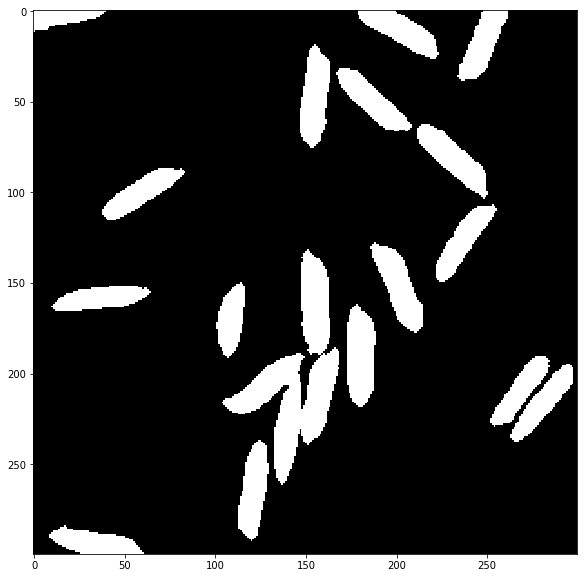

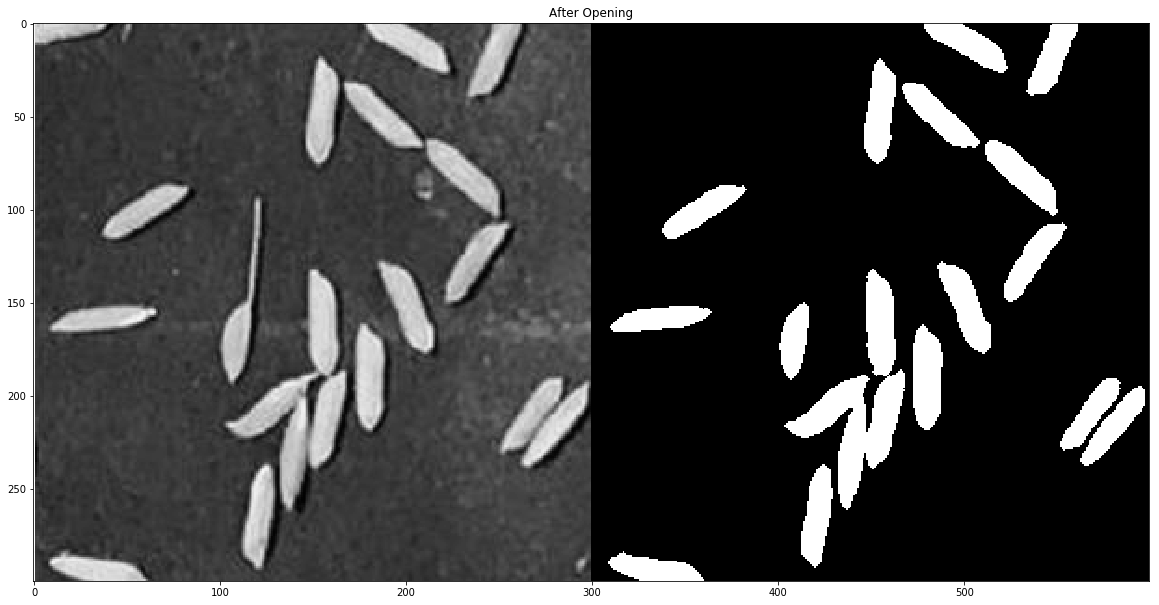

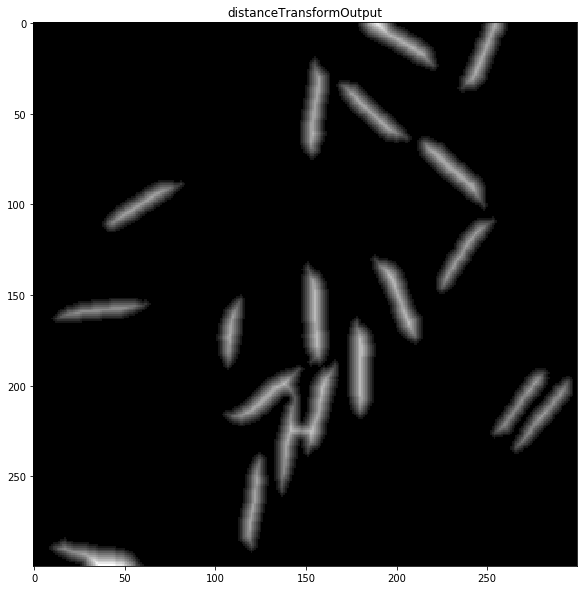

Max Distance: 10.505


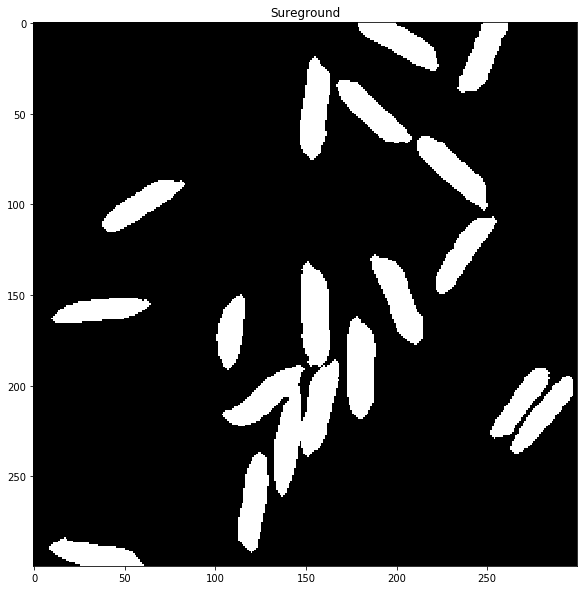

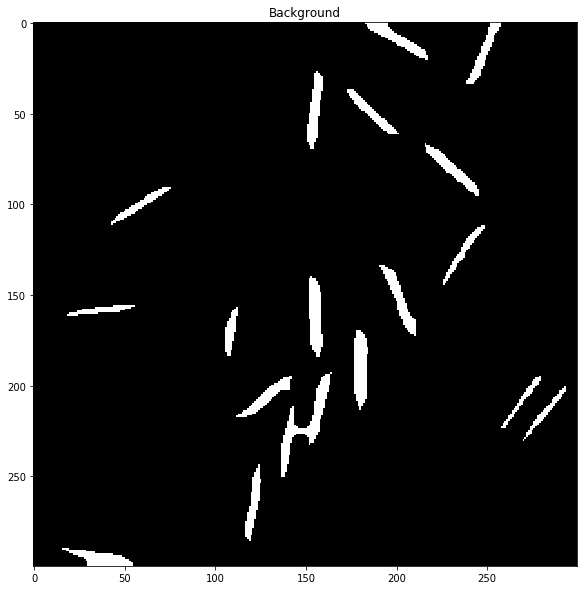

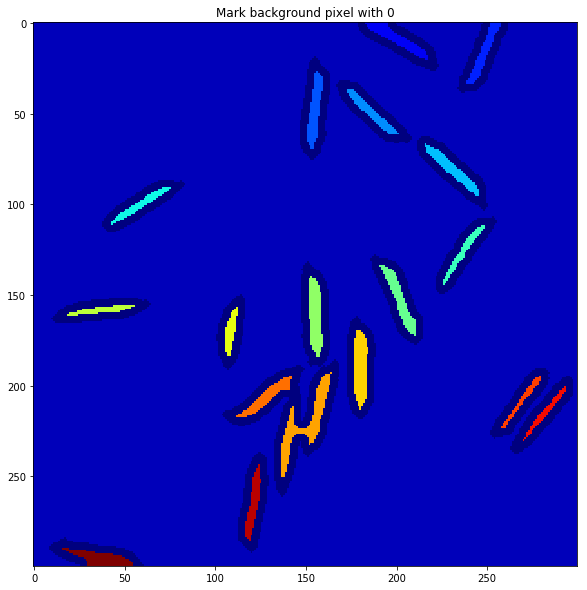

Count: 18


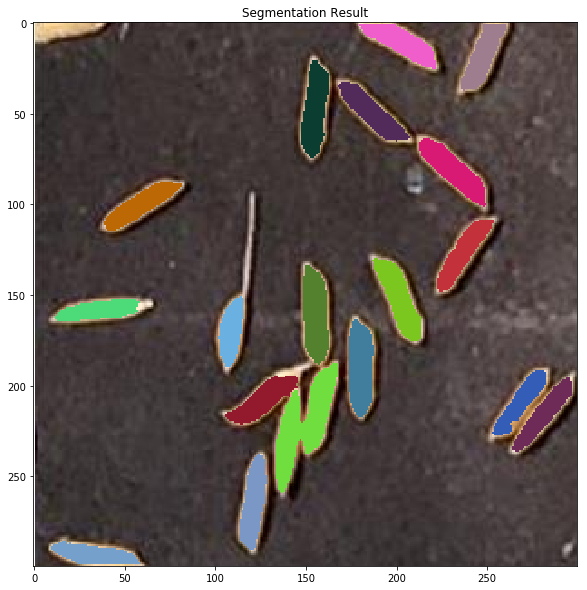

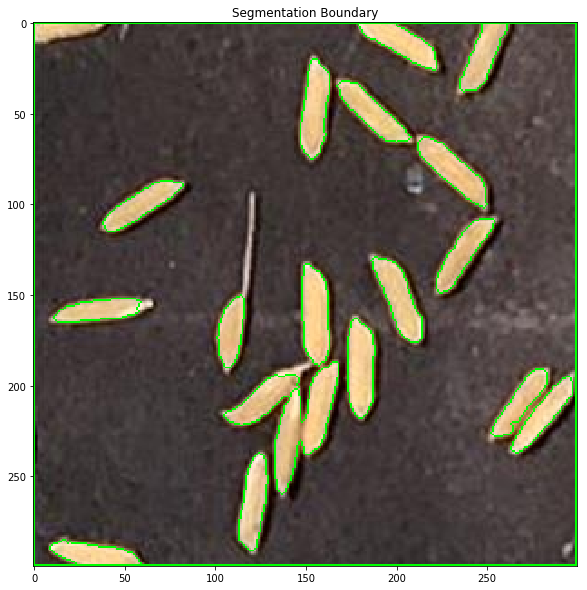

# 1 : Area =  425.5
# 2 : Area =  393.0
# 3 : Area =  494.5
# 4 : Area =  442.5
# 5 : Area =  497.5
# 6 : Area =  410.0
# 7 : Area =  407.0
# 8 : Area =  510.5
# 9 : Area =  549.5
# 10 : Area =  335.5
# 11 : Area =  319.5
# 12 : Area =  553.0
# 13 : Area =  934.5
# 14 : Area =  427.0
# 15 : Area =  342.5
# 16 : Area =  382.5
# 17 : Area =  446.5
# 18 : Area =  345.0
# 1 RGB [246.16701903 208.95983087 155.12684989]
# 2 RGB [227.18451025 192.54669704 149.39179954]
# 3 RGB [235.79636364 199.04545455 152.01454545]
# 4 RGB [231.69958848 200.27572016 144.62139918]
# 5 RGB [233.59116022 192.21915285 142.70165746]
# 6 RGB [224.84175824 192.63736264 146.81758242]
# 7 RGB [222.90066225 185.58057395 138.16777042]
# 8 RGB [232.37477798 199.87921847 151.24333925]
# 9 RGB [244.21416804 205.42833608 150.68204283]
# 10 RGB [231.27012987 200.91688312 154.44155844]
# 11 RGB [231.08055556 192.24722222 147.08055556]
# 12 RGB [241.0591133  205.89655172 155.39573071]
# 13 RGB [231.22854388 193.28640309 145.

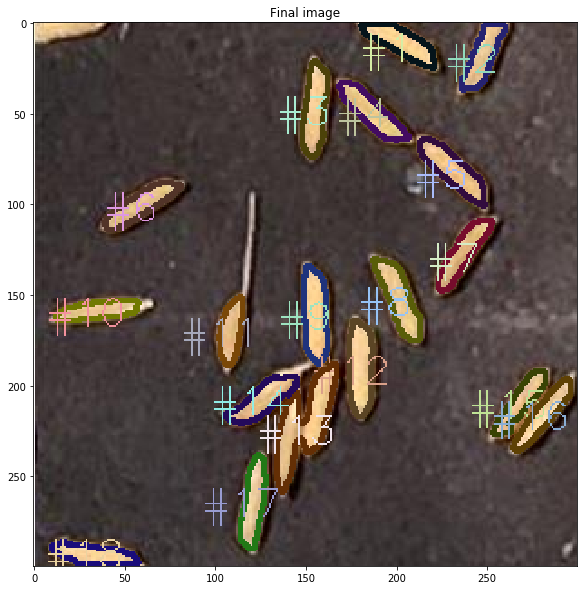

In [541]:
testImplement()

assets/05.11.61/13.02.62_11.59.jpg
1 [244.46180556 200.84027778 136.95659722]
2 [245.60175439 209.70877193 145.65964912]
3 [241.41547862 198.74338086 136.41344196]
4 [245.20262664 204.18761726 140.58161351]
5 [243.49003984 197.1314741  136.10358566]
6 [249.04439252 216.0864486  147.45327103]
7 [248.6502947  215.09037328 148.64243615]
8 [240.26551724 203.67241379 146.94482759]
9 [247.61688312 213.19047619 143.35281385]
10 [249.24190065 207.87473002 139.81641469]
11 [246.00706714 206.36042403 144.94699647]
12 [243.41684665 201.50107991 141.86609071]
13 [240.2877095  192.96368715 122.19832402]
14 [243.46972477 206.99082569 144.5266055 ]
15 [247.32391714 210.7306968  147.15819209]
16 [249.66534653 217.49306931 159.20594059]
17 [235.31758034 186.01512287 117.92249527]
18 [247.84987893 212.97820823 157.35108959]
19 [240.         202.83887468 140.38618926]
20 [251.29081633 212.94642857 155.22193878]


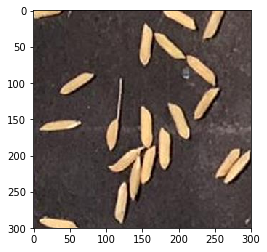

In [525]:
filepath = filePath("05.11.61")[4]
print(filepath)
inputImage = cv2.imread(filepath)
cropImage = inputImage[300:600,0:300]
riceImage = cv2.cvtColor(cropImage,cv2.COLOR_BGR2RGB)

plt.imshow(riceImage)
# b = 1
# a = 0
# print(riceImage[riceLocation[b][0][a]][riceLocation[b][1][a]])
# print('riceLocation',riceLocation[b][0][a],riceLocation[b][1][a])
# print('riceLocation',riceColors[b][a])
for i in range(len(riceColors)):
    print(i+1,np.mean(riceColors[i+1], axis=0))

## Test

['assets/05.11.61/05.11.61_12.09.JPG', 'assets/05.11.61/05.11.61_12.08.JPG', 'assets/05.11.61/05.11.61_12.10.JPG', 'assets/05.11.61/05.11.61_12.07.JPG']


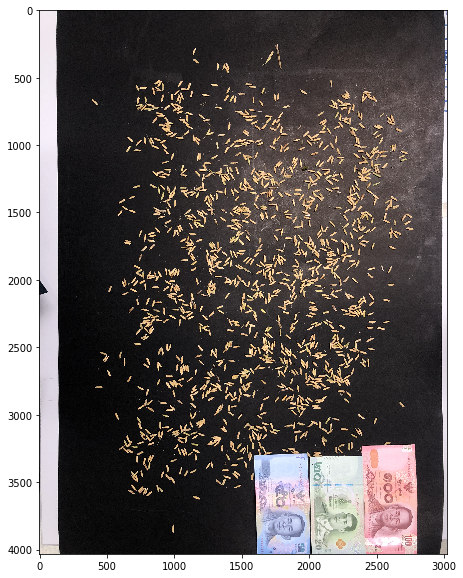

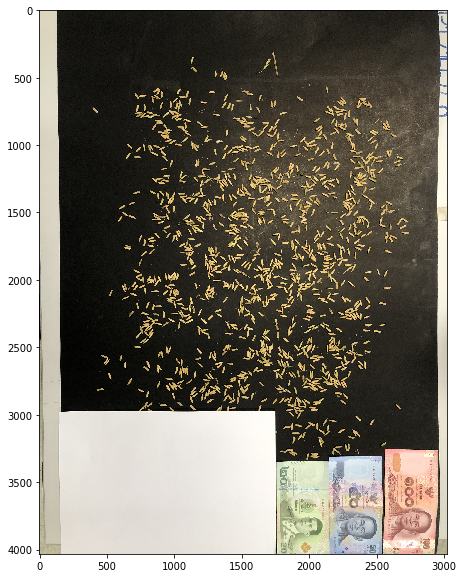

In [121]:
filepath = filePath("05.11.61")[0:4]
print(filepath)
inputImage1 = cv2.imread(filePath()[0])
inputImage1 = cv2.cvtColor(inputImage1, cv2.COLOR_BGR2RGB)
inputImage2 = cv2.imread(filePath()[2])
inputImage2 = cv2.cvtColor(inputImage2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(inputImage1)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(inputImage2)
plt.show()

## Rice 05.11.61

assets/05.11.61/13.02.62_11.59.jpg


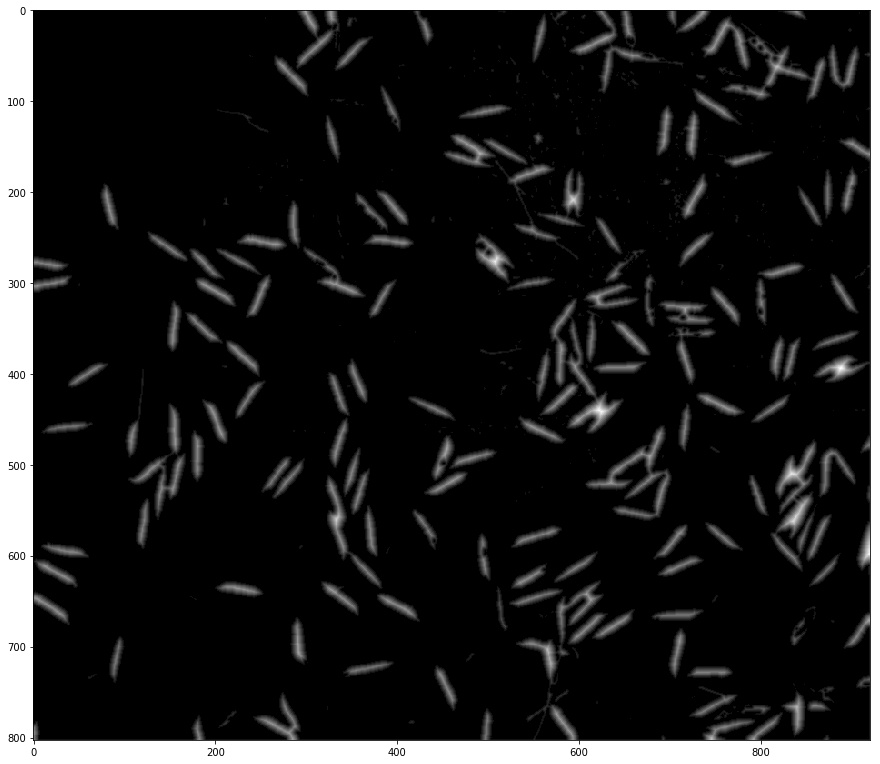

Max Distance: 13.2787


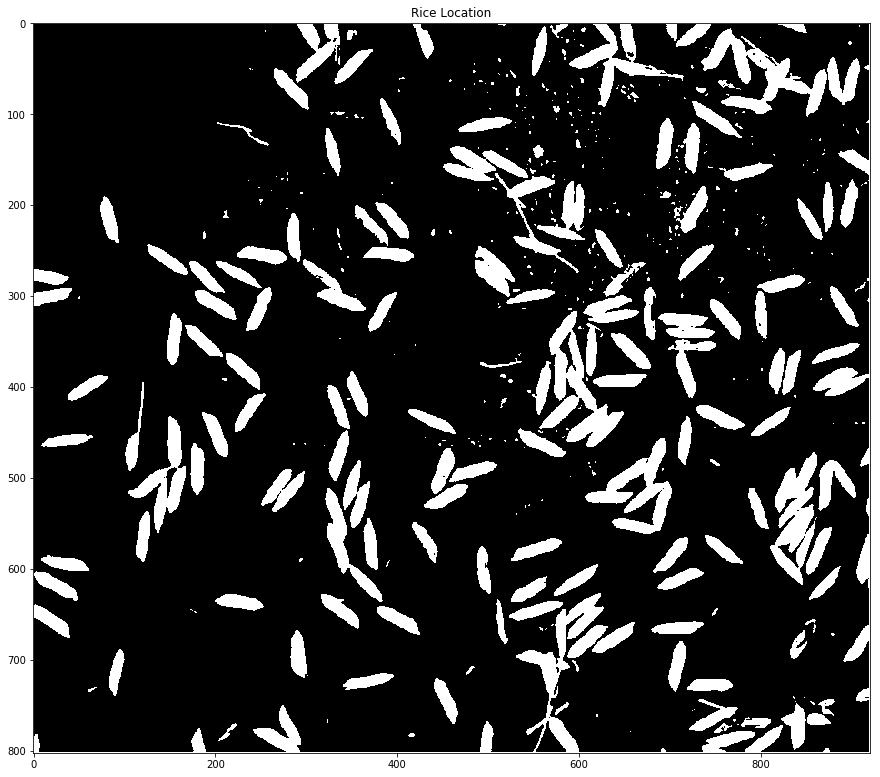

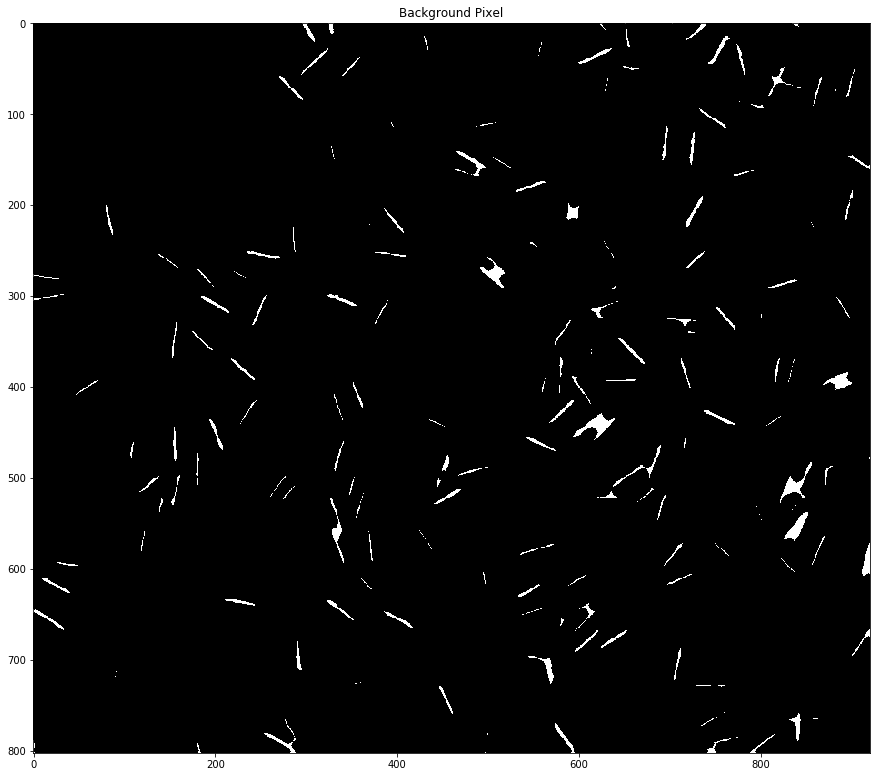

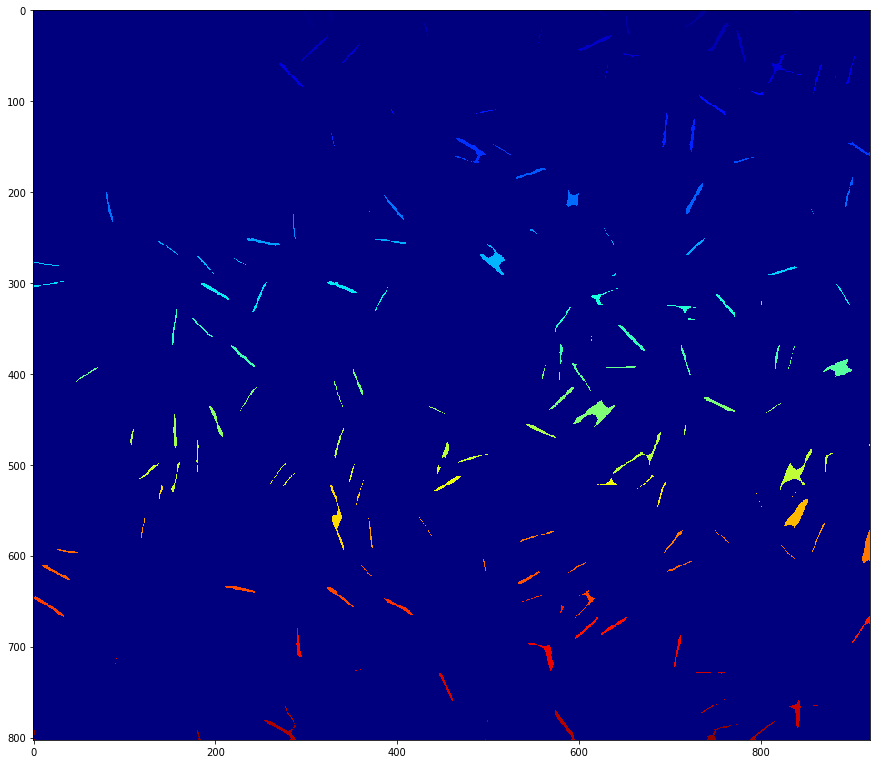

Count: 268


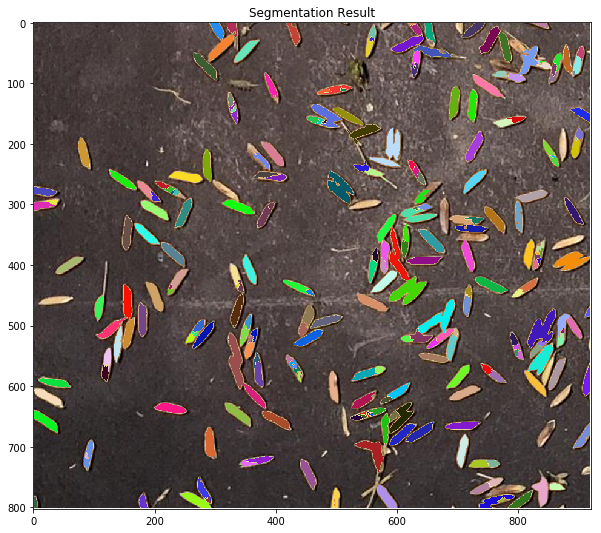

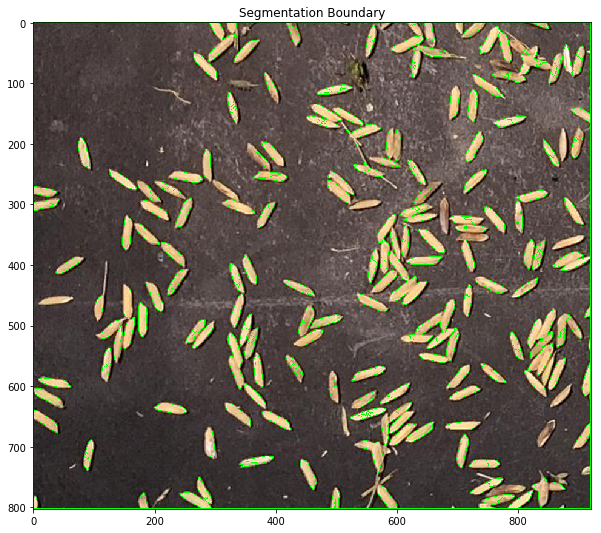

In [37]:
inputImage = cv2.imread(filePath("05.11.61")[4])
print(filePath("05.11.61")[4])
# cropImage = inputImage[250:750,250:750]
cropImage = inputImage
# plotImageByThroshold(cropImage)
plotConnectedComponents(cropImage)
# showImage(cropImage)

## Rice 08.10.61

In [1]:
inputImage = cv2.imread(filePath("08.10.61")[0])
# plotImageByThroshold(inputImage)
plotConnectedComponents(inputImage[200:300,0:400])
# showImage(inputImage)

NameError: name 'cv2' is not defined

## KNN Algorithm

In [199]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [348]:
dataset = pd.read_csv('exampleSpecie.csv')
dataset

Length  Width     Species
0      5.3    3.7      Setosa
1      5.1    3.8      Setosa
2      7.2    3.0   Virginica
3      5.4    3.4      Setosa
4      5.1    3.3      Setosa
5      5.4    3.9      Setosa
6      7.4    2.8   Virginica
7      6.1    2.8  Versicolor
8      7.3    2.9   Virginica
9      6.0    2.7  Versicolor
10     5.8    2.8   Virginica
11     6.3    2.3  Versicolor
12     5.1    2.5  Versicolor
13     6.3    2.5  Versicolor
14     5.5    2.4  Versicolor

In [367]:
# Replace Zeroes
zero_not_accepted = ['Length','Width']

for column in zero_not_accepted:
    dataset[column] = dataset[column].replace(0, np.NaN)
    mean = int(dataset[column].mean(skipna=True))
    dataset[column] = dataset[column].replace(np.NaN, mean)

In [402]:
# Split dataset
X = dataset.iloc[:,:-1]
Y = dataset.iloc[:,2]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=1)
# Test Data
d = [{'Length': '5.2','Width': '3.8'},
     {'Length': '7.1','Width': '3.1'},
     {'Length': '5.4','Width': '3.1'},]
X_test = pd.DataFrame(d)
arrD = ['Setosa','Virginica','Versicolor']
d = {k:v for k,v in zip(range(1,len(arrD)+1),arrD)}
Y_test = pd.Series(d, name='Species')

In [403]:
# Feature Scaling
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [404]:
# KNN Classifier
classifier = KNeighborsClassifier(n_neighbors=3, p=2, metric='euclidean')
classifier.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [405]:
#  Prediction
Y_pred = classifier.predict(X_test)
Y_pred

array(['Setosa', 'Virginica', 'Setosa'], dtype=object)

In [406]:
print(accuracy_score(Y_test, Y_pred))

0.6666666666666666


In [522]:
# Confusion Matrix
cm = confusion_matrix(Y_test, Y_pred)
print(cm)
# Prediction Result
print(classification_report(Y_test, Y_pred))

[[1 0 0]
 [1 0 0]
 [0 0 1]]
             precision    recall  f1-score   support

     Setosa       0.50      1.00      0.67         1
 Versicolor       0.00      0.00      0.00         1
  Virginica       1.00      1.00      1.00         1

avg / total       0.50      0.67      0.56         3



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0,0.5,'Mean Error')

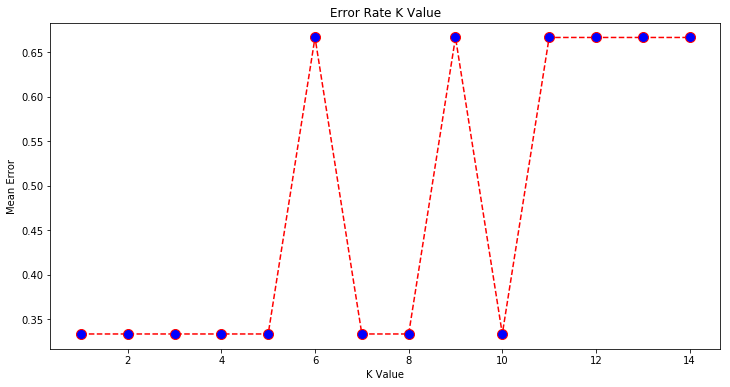

In [408]:
error = []

# Calculating error for K values
for i in range(1, len(dataset)):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != Y_test))
    
plt.figure(figsize=(12, 6))  
plt.plot(range(1, len(dataset)), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  